In [1]:
# Original Code Template by Stephen Siemonsma

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append("..")
sys.path.append("../DiffJPEG")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms as T
from abc import ABC, abstractmethod
from torchvision.datasets.vision import VisionDataset
from typing import Callable, cast, List, Optional, Tuple, Union
from pathlib import Path
from glob import glob
from torchvision.datasets.utils import _read_pfm, download_and_extract_archive, verify_str_arg
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from DiffJPEG import DiffJPEG
from modules import compress_jpeg, decompress_jpeg
from utils import diff_round, quality_to_factor
import math
from tqdm import tqdm
from torchvision import datasets
import random
import time
import functools
from torchvision import transforms
from torch.nn import Module
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [2]:
_read_pfm_file = functools.partial(_read_pfm, slice_channels=1)  # For reading PFM (Portable FloatMap) files from FlyingThings3D dataset

In [3]:
# Modified version of a PyTorch dataloader
class MonkaaDataset(ABC, VisionDataset):
    """Base interface for Stereo matching datasets"""

    _has_built_in_disparity_mask = False

    def __init__(self, root: str, train_or_test: str, validation_or_nonvalidation: str, transforms: Optional[Callable] = None) -> None:
        """
        Args:
            root(str): Root directory of the dataset.
            transforms(callable, optional): A function/transform that takes in Tuples of
                (images, disparities, valid_masks) and returns a transformed version of each of them.
                images is a Tuple of (``PIL.Image``, ``PIL.Image``)
                disparities is a Tuple of (``np.ndarray``, ``np.ndarray``) with shape (1, H, W)
                valid_masks is a Tuple of (``np.ndarray``, ``np.ndarray``) with shape (H, W)
                In some cases, when a dataset does not provide disparities, the ``disparities`` and
                ``valid_masks`` can be Tuples containing None values.
                For training splits generally the datasets provide a minimal guarantee of
                images: (``PIL.Image``, ``PIL.Image``)
                disparities: (``np.ndarray``, ``None``) with shape (1, H, W)
                Optionally, based on the dataset, it can return a ``mask`` as well:
                valid_masks: (``np.ndarray | None``, ``None``) with shape (H, W)
                For some test splits, the datasets provides outputs that look like:
                imgaes: (``PIL.Image``, ``PIL.Image``)
                disparities: (``None``, ``None``)
                Optionally, based on the dataset, it can return a ``mask`` as well:
                valid_masks: (``None``, ``None``)
        """
        super().__init__(root=root)
        self.transforms = transforms  # You can load up the transforms argument with you data augmentation
        self.validation_or_nonvalidation = validation_or_nonvalidation
        self.train_or_test = train_or_test

        self._images = []  # type: ignore
        # self._disparities = []  # type: ignore
        
        root = Path(root)

        if train_or_test == "TRAIN":
            left_image_pattern = str(root / "../../Monkaa/frames_cleanpass/TRAINING" / validation_or_nonvalidation / "*/left/*.png")
            # left_disparity_pattern = str(root / "../../Monkaa/disparity/TRAINING" / validation_or_nonvalidation / "*/left/*.pfm")
        elif (train_or_test == "TESTING2"):
            left_image_pattern = str(root / "../../Monkaa/frames_cleanpass/*/left/*.png")
            # left_disparity_pattern = str(root / "../../Monkaa/disparity/*/left/*.pfm")
        else:
            left_image_pattern = str(root / "../../Monkaa/frames_cleanpass/TESTING/*/left/*.png")
            # left_disparity_pattern = str(root / "../../Monkaa/disparity/TESTING/*/left/*.pfm")
            
        
        # self._disparities += self._scan_pairs(left_disparity_pattern)
        self._images += self._scan_pairs(left_image_pattern)


    def _read_img(self, file_path: Union[str, Path]) -> Image.Image:
        img = Image.open(file_path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

    def _scan_pairs(self, paths_left_pattern: str):
        left_paths = list(sorted(glob(paths_left_pattern)))

        if not left_paths:
            raise FileNotFoundError(f"Could not find any files matching the patterns: {paths_left_pattern}")

        paths = left_paths
        return paths

    # function for reading disparity maps
    def _read_disparity(self, file_path: str) -> Tuple[np.ndarray, None]:
        disparity_map = _read_pfm_file(file_path)
        disparity_map = np.abs(disparity_map)  # Ensure that the disparity is positive
        valid_mask = None
        return disparity_map

    def __getitem__(self, index: int) -> np.ndarray:
        """Return example at given index.

        Args:
            index(int): The index of the example to retrieve

        Returns:
            tuple: A 3 or 4-tuple with ``(img_left, img_right, disparity, Optional[valid_mask])`` where ``valid_mask``
                can be a numpy boolean mask of shape (H, W) if the dataset provides a file
                indicating which disparity pixels are valid. The disparity is a numpy array of
                shape (1, H, W) and the images are PIL images. ``disparity`` is None for
                datasets on which for ``split="test"`` the authors did not provide annotations.
        """
        
        # Only used the left disparity map, but we can use either (maybe just randomize it)
        # dsp_map_left = self._read_disparity(self._disparities[index])
        img_left = self._read_img(self._images[index])
        
        # dsp_maps = torch.from_numpy(dsp_map_left)
        img_maps = torch.from_numpy(np.array(img_left))
        img_maps = img_maps.permute(2, 0, 1) # this reshapes our tensor so we can combine RGB+D
        
        # dsp_maps[dsp_maps <= 0] = 1e-6  # In case there are any disparities that equal 0, we need to make them a small positive value so that depth is never calculated as infinity (for depth normalization purposes)
            
        # depth_maps = 1 / dsp_maps        
        img_maps = img_maps / 255 # normalize the RGB values to a range [0, 1]
        
        # rgbd_map = torch.cat((img_maps, depth_maps), dim=0) # combine RGB + D tensors
        if self.transforms is not None: # perform transforms on ALL 4 channels
            img_maps = self.transforms(img_maps)
 
        # print(rgbd_map.shape)
        # print("Depth map shape:", depth_maps.shape)
        # print("Image map shape:", img_maps.shape)
        # print("RGB-D map shape:", rgbd_map.shape)
        # print("RGB-D map DATA:", rgbd_map[0][0])

        return img_maps


    def __len__(self) -> int:
        return len(self._images)

In [4]:
batch_size = 1

transforms = None

# Create Testing Dataset
test_dataset = MonkaaDataset("", "TESTING", "", transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False) # for training (shuffle)
eval_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False) # for evaluation (do NOT shuffle)


In [5]:
print(test_dataset[0].shape)

torch.Size([3, 540, 960])


In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Output: [16, x/2, y/2]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output: [32, x/4, y/4]
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                      # Output: [64, 1, 1]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Assuming input is normalized to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("mps")  # For M-series Macs
#device = torch.device("cpu")  # For slow training on CPU
#device = torch.device("cuda")  # For NVIDIA cards

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# This is a really cool learning rate scheduler, but we could see it resulting in overfitting for a model that is succeptible to that
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5066, 1)

MSE_criterion = nn.MSELoss()
L1_criterion = nn.L1Loss()
BCE_criterion = nn.BCEWithLogitsLoss()

In [6]:
# --------------------------------------- SMALLER LATENT SPACE MODEL ---------------------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Output: [16, x/2, y/2]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output: [32, x/4, y/4]
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                      # Output: [64, 1, 1]
            nn.ReLU(),  # Additional ReLU layer for non-negative output
            nn.Conv2d(64, 8, 1)                      # Output: [8, 1, 1] - Further reduction to a smaller latent space
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 64, 1),             # Reverse of encoder layers
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Assuming input is normalized to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("mps")  # For M-series Macs
#device = torch.device("cpu")  # For slow training on CPU
#device = torch.device("cuda")  # For NVIDIA cards

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# This is a really cool learning rate scheduler, but we could see it resulting in overfitting for a model that is susceptible to that
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5066, 1)

MSE_criterion = nn.MSELoss()
L1_criterion = nn.L1Loss()
BCE_criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Training the autoencoder
training_losses = []
validation_losses = []
num_training_epochs = 50
best_MSE_loss = torch.inf

for j in range(num_training_epochs):
    progress_bar = tqdm(test_loader, position=0) # use the data loader that is shuffled for training

    acc_MSE_loss = 0 # track the accumulated MSE losses
    acc_RMSE_loss = 0 # track the accumulated RMSE losses
    
    for i, depth_maps in enumerate(progress_bar):
        optimizer.zero_grad()

        depth_maps = depth_maps.to(device) # this tensor contains RGB+D

        recovered_data = model(depth_maps) # run the input through the model to get our recovered data
        loss = MSE_criterion(recovered_data, depth_maps)
        loss.backward()
        
        optimizer.step()
        # scheduler.step()
        acc_MSE_loss += loss.item()
        progress_bar.set_description('Epoch %i Training %i' % (j, i+1))
        progress_bar.set_postfix_str('%.4f' % (acc_MSE_loss/(i+1))) # display the avg MSE loss
    total_loss = (acc_MSE_loss / 1594)
    training_losses.append(total_loss) # append the total loss for later plotting

    if total_loss < best_MSE_loss:
        best_MSE_loss = total_loss
        weights = model.state_dict()
        torch.save(weights, "./weights/clusterModel.weights")

Epoch 22 Training 238:  23%|█▏   | 236/1012 [00:06<00:22, 35.25it/s, 0.0007]

In [12]:
# Feature extraction for clustering
weights = torch.load("./weights/clusterModel.weights")
model.load_state_dict(weights)
model.eval()

features = torch.Tensor().to(device)  # Initialize an empty tensor on the device if possible
with torch.no_grad():
    for i, data in enumerate(eval_loader): # use the data loader that is NOT shuffled since we will be evaluating these images in order
        inputs = data.to(device)
        encoded_features = model.encoder(inputs)
        encoded_features = encoded_features.view(inputs.size(0), -1)  # Flatten the features
        if i % 10 == 0 and i > 0:  # Every 10 batches, concatenate and clear the list
            features = torch.cat((features, encoded_features), dim=0)
            encoded_features = torch.Tensor().to(device)  # Re-initialize to free memory
        else:
            features = torch.cat((features, encoded_features), dim=0)

# Final concatenation if there are any remaining tensors
if len(encoded_features) > 0:
    features = torch.cat((features, encoded_features), dim=0)


In [15]:
# Ensure the tensor is on CPU before converting to NumPy
features_np = features.cpu().numpy()

# Proceed with KMeans clustering
kmeans = KMeans(n_clusters=7) # Input number of scenes for clustering
clusters = kmeans.fit_predict(features_np) # Run the clustering algorithm on our extracted features from the input data

In [ ]:
np.set_printoptions(threshold=np.inf) # print everything, don't limit the output. ONLY for TESTING
print(clusters)

In [ ]:
# We can build our ground truth array since we know the order of the data being loaded and how many frames each has
ground_truth = []

for i in range(126): # rain of stones
    ground_truth.append(0)
for i in range(151): # eating camera 2
    ground_truth.append(1)
for i in range(91): # eating
    ground_truth.append(2)
for i in range(161): # family
    ground_truth.append(3)
for i in range(231): # lonetree difftex
    ground_truth.append(4)
for i in range(161): # lonetree winter
    ground_truth.append(5)
for i in range(197): # top view
    ground_truth.append(6)

# print(ground_truth)


In [19]:
# Assuming ground_truth_labels is the array with ground truth labels
# Assuming clusters is the array with the clustering results

# Calculate Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(ground_truth, clusters)

# Calculate Adjusted Mutual Information (AMI)
ami_score = adjusted_mutual_info_score(ground_truth, clusters)

print("Adjusted Rand Index (ARI):", ari_score)
print("Adjusted Mutual Information (AMI):", ami_score)

Adjusted Rand Index (ARI): 0.961499703374664
Adjusted Mutual Information (AMI): 0.9673005080338367


30


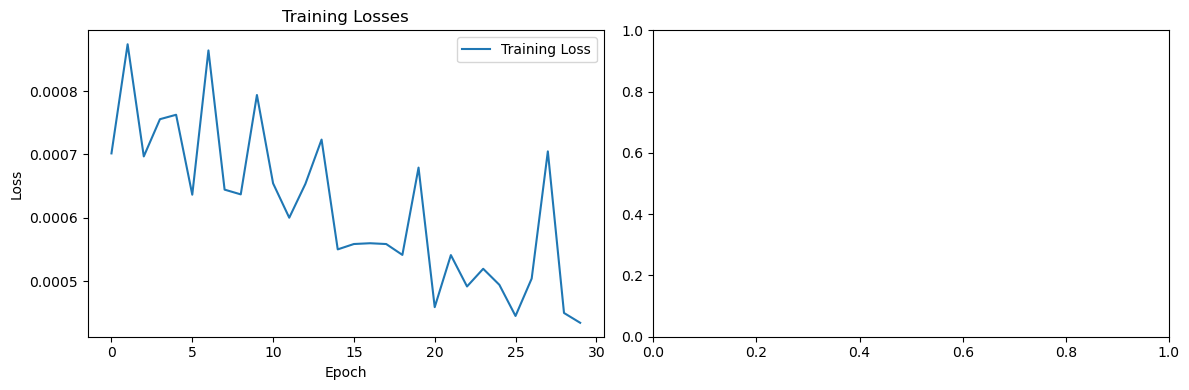

In [20]:
print(len(training_losses))
# print(len(validation_losses))

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # figsize can be adjusted to your preference
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # figsize can be adjusted to your preference

# Plot training losses
axs[0].plot(training_losses, label='Training Loss')
axs[0].set_title('Training Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot validation losses
# axs[1].plot(validation_losses, label='Validation Loss')
# axs[1].set_title('Validation Losses')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Loss')
# axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [130]:
# Save final model, too, if you want, but it probably won't be the best
weights = net.state_dict()
torch.save(weights, "./weights/colorful_depth_compression_ending.weights")

In [ ]:
plt.plot(test_overall_histogram)